In [22]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Set random seed
np.random.seed(42)

# Load and clean the CSV
df = pd.read_csv("../Data/^GSPC.csv")
df = df[df["Price"] != "Ticker"]
df = df[df["Price"] != "Date"]
df[['Close','High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)
df['Price'] = pd.to_datetime(df['Price'])
df.set_index('Price', inplace=True)
df.index.name = None

# Define feature generation
def add_features(data):
    """Create additional technical indicators and prediction target while keeping alignment intact"""
    df = data.copy()

    # Technical indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Return'] = df['Close'].pct_change()

    # Feature engineering
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)

    # Target: use binary or multi-class depending on your setup
    df['Target'] = np.where(df['Return'].shift(-1) > 0.005, 2,
                    np.where(df['Return'].shift(-1) < -0.005, 0, 1))

    return df  # ❗ Keep full index, no dropna()

# Helper functions to extract features and labels
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    return data.Target.values

# Apply features
df = add_features(df)


In [23]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

class XGBoostStrategy(Strategy):
    price_delta = 0.01
    lookback_window = 200
    n_estimators = 100
    max_depth = 5
    learning_rate = 0.1
    
    def init(self):
        # Feature + label prep
        full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')
        self.all_data = full_df.loc[self.data.df.index.intersection(full_df.index)]
        
        # Extract features
        self.features = [col for col in self.all_data.columns if col.startswith("X_")]
        
        # Initialize model
        self.model = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
        
        # Prediction tracking
        self.predictions = []
        self.actuals = []
        
    def next(self):
        # Current position in the backtest
        current_idx = len(self.data) - 1
        
        # Safety check - make sure we have enough data
        if current_idx < self.lookback_window:
            return
            
        # Get current data index
        current_candle_time = self.data.index[-1]
        
        try:
            # Find corresponding index in our all_data DataFrame
            idx_in_all_data = self.all_data.index.get_indexer([current_candle_time])[0]
            
            # Check if valid index found
            if idx_in_all_data < 0 or idx_in_all_data < self.lookback_window:
                return
                
            # Safe slicing with loc instead of iloc
            start_idx = self.all_data.index[idx_in_all_data - self.lookback_window + 1]
            end_idx = self.all_data.index[idx_in_all_data]
            train_data = self.all_data.loc[start_idx:end_idx].iloc[:-1]  # All but last point
            test_data = self.all_data.loc[end_idx:end_idx]  # Just the last point
            
            # Check if we have enough data
            if len(train_data) < self.lookback_window // 2:
                return
                
            # Extract features and target
            X_train = train_data[self.features].values
            y_train = train_data["Target"].values
            X_test = test_data[self.features].values
            y_true = test_data["Target"].values[0]
            
            # Train model dynamically on each call
            self.model.fit(X_train, y_train)
            
            # Make prediction
            prediction = self.model.predict(X_test)[0]
            
            # Convert prediction from 0,1,2 to -1,0,1 if needed
            if set(np.unique(y_train)) == {0, 1, 2}:
                prediction_map = {0: -1, 1: 0, 2: 1}
                prediction = prediction_map.get(prediction, prediction)
                
            # Log predictions and labels
            if prediction in [-1, 0, 1]:
                self.predictions.append(prediction)
                self.actuals.append(int(y_true))
                
            # Trade execution with take-profit and stop-loss
            close = self.data.Close[-1]
            tp_long = close * (1 + self.price_delta)
            sl_long = close * (1 - self.price_delta)
            tp_short = close * (1 - self.price_delta)
            sl_short = close * (1 + self.price_delta)
            
            # Trading logic
            if prediction == 1:
                if not self.position.is_long:
                    self.position.close()
                    self.buy(tp=tp_long, sl=sl_long)
                    
            elif prediction == -1:
                if not self.position.is_short:
                    self.position.close()
                    self.sell(tp=tp_short, sl=sl_short)
                    
            # Risk management with trailing stop
            for trade in self.trades:
                if self.data.index[-1] - trade.entry_time > pd.Timedelta(days=5):
                    if trade.is_long:
                        trade.sl = max(trade.sl, trade.entry_price)
                    else:
                        trade.sl = min(trade.sl, trade.entry_price)
                        
        except (IndexError, KeyError) as e:
            # Handle exceptions gracefully to avoid breaking the backtest
            pass

In [24]:
bt = Backtest(df, XGBoostStrategy, cash=10_000, commission=.0002)
backtest = bt.run()

/var/folders/bg/6x82p8q55dxf8pb_c34j03mm0000gn/T/ipykernel_34606/2762141933.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features(self.data.df).fillna(method='ffill').fillna(method='bfill')


Backtest.run:   0%|          | 0/986 [00:00<?, ?bar/s]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:35:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

In [25]:
backtest

Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    56.02837
Equity Final [$]                   7052.25744
Equity Peak [$]                       10000.0
Commissions [$]                     775.11716
Return [%]                          -29.47743
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                    -8.53072
Volatility (Ann.) [%]                 5.15524
CAGR [%]                             -5.97288
Sharpe Ratio                         -1.65477
Sortino Ratio                        -1.91205
Calmar Ratio                         -0.26648
Alpha [%]                           -30.56797
Beta                                   0.0241
Max. Drawdown [%]                   -32.01256
Avg. Drawdown [%]                   -32.01256
Max. Drawdown Duration     1142 days 00:00:00
Avg. Drawdown Duration     1142 days 00:00:00
# Trades                          

In [26]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (0)', 'Neutral (1)', 'Up (2)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [27]:
bt.plot()

GridPlot(id='p2135', ...)

Evaluation Metrics
Accuracy: 0.2173
Precision (macro): 0.1607
F1 Score (macro): 0.1461


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


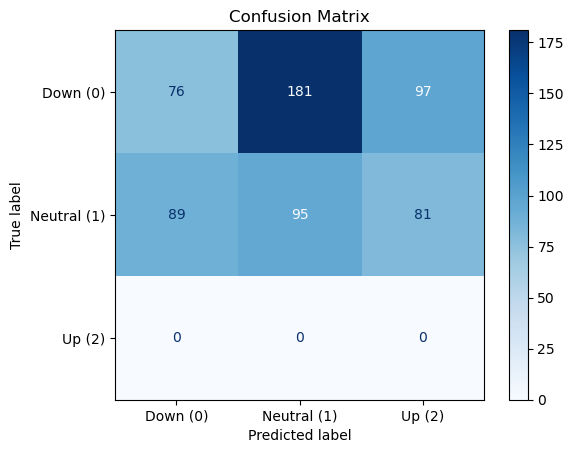

In [28]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)